In [1]:
%matplotlib inline
import os
import os.path as op
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg 
import seaborn as sns

In [2]:
#leading preprocessed eeg
subj = "sub-006"
examples_dir = "/home/a.ghaderi/Data/raw/"+subj+"/sourcedata-eeg_outside-MRT/eeg/"
epochs = mne.read_epochs(examples_dir + subj + "_final_preprocessing_IIR_60.fif");

epochs_sub  = epochs.get_data()

erp_sub = epochs.average().data.T

Reading /home/a.ghaderi/Data/raw/sub-006/sourcedata-eeg_outside-MRT/eeg/sub-006_final_preprocessing_IIR_60.fif ...


<ipython-input-2-9375138a497e>:4: RuntimeWarning: This filename (/home/a.ghaderi/Data/raw/sub-006/sourcedata-eeg_outside-MRT/eeg/sub-006_final_preprocessing_IIR_60.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(examples_dir + subj + "_final_preprocessing_IIR_60.fif");


    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =     -99.61 ...     400.39 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [3]:
# Weighted channels in the 125-225 msec windows
lower_125 = int((1024/1000)*(100+125))
upper_225 = int((1024/1000)*(100+225))

# Extraction of singla-trial N200 latency in the 100-250 window
lower_lat = int((1024/1000)*(100+100))
upper_lat = int((1024/1000)*(100+250))

In [4]:
#svd for subject to decompose underlying component
u_sub, s_sub, vh_sub  = linalg.svd(erp_sub[lower_125:upper_225], full_matrices=False)

In [5]:
#how much of the variability is explained by each comonent
varaince = (100*np.power(s_sub,2)/np.sum(np.power(s_sub,2)))[0]
print('variance for left:',varaince)

variance for left: 92.39769253930946


In [6]:
u_sub.shape, s_sub.shape, vh_sub.shape

((102, 62), (62,), (62, 62))

In [9]:
#weight of subject component one related to slacp map
weights_sub = vh_sub[0,:]
if subj in ["sub-001","sub-005","sub-008"]:
    weights_sub = -weights_sub

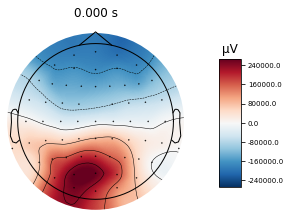

In [11]:
#coponent realting to subject
_ = mne.EvokedArray(weights_sub.reshape(62,1), epochs.info).plot_topomap(times=0, size=2).savefig("figs/"+subj + '_map.png')

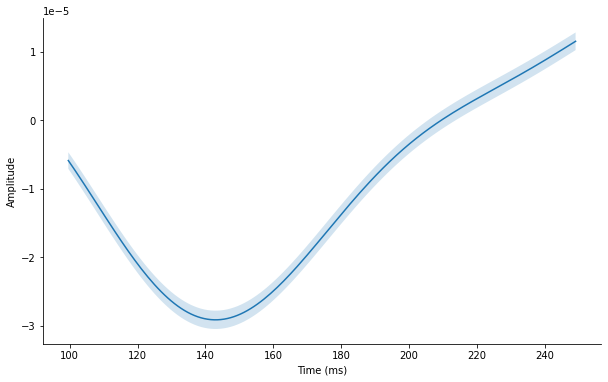

In [13]:
#single trial EEG left
single_epoch_sub = np.zeros([288,upper_lat-lower_lat])
for i in range(288):
    single_epoch_sub[i] = np.dot(weights_sub, epochs_sub[:,:,lower_lat:upper_lat][i])

plt.figure(figsize=(10,6))
plt.plot(1000*epochs.times[lower_lat:upper_lat], single_epoch_sub.mean(axis=0))

#standard error for high coherence for 72*144 smaple (trials*points) condition 1
std_error_sub = single_epoch_sub.std(axis=0)/np.sqrt(288)
plt.fill_between(1000*epochs.times[lower_lat:upper_lat], single_epoch_sub.mean(axis=0) -std_error_sub,
                 single_epoch_sub.mean(axis=0) +std_error_sub, alpha=0.2)

#plt.title(subj)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
sns.despine()
plt.savefig('figs/'+subj + '_n200.png')
#-----------------------------------------------------------------

In [627]:
#plt.imshow(single_epoch_sub, cmap=plt.cm.RdBu_r, aspect='auto', extent=[125,225,0,288])
#plt.colorbar()

In [628]:
### Get Latency in a window 150-225 and save it 

###### minimum latancy in the time window

In [15]:
n200lat_sub = ((np.argmin(single_epoch_sub, axis=1)+lower_lat)*(1000/1024) - 100)/1000

/home/a.ghaderi/.conda/envs/envjm/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


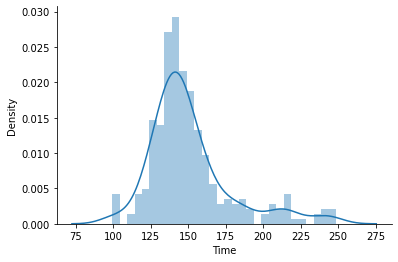

In [16]:
plt.figure()
sns.distplot(1000*n200lat_sub,bins=30)
#plt.title(subj)
plt.xlabel("Time")
sns.despine()
plt.savefig('figs/'+subj + '_n200_dist.png')

In [18]:
###### Adding a column to the behavioral data
examples_dir_beh = "/home/a.ghaderi/Data/raw/"+subj+"/sourcedata-eeg_outside-MRT/beh/"+subj+"_task-pdm_acq-outsideMRT_runs_beh"
df = pd.read_csv(examples_dir_beh +'.csv', index_col=False)
# new columnn as n200lat
df['n200lat'] = n200lat_sub
df.to_csv(examples_dir_beh +'_n200lat.csv', index=False)
print("latency for " + subj + " has been successfully saved")

latency for sub-006 has been successfully saved


# Figures

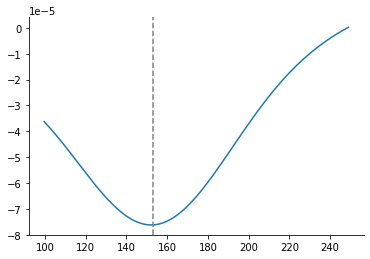

In [17]:
i = 96
plt.plot(1000*epochs.times[lower_lat:upper_lat],single_epoch_sub[i])
plt.axvline(x=153,color='gray', linestyle='--')

sns.despine()
plt.savefig('figs/n200lat-exraction/'+subj + '_'+str(i)+'_single_n200.png')